In [2]:
import math
import numpy as np
import scipy.io as sio
import matplotlib 
from matplotlib import pyplot as plt
from random import randint
%matplotlib inline

In [8]:
d = 12
n = 5000
data = sio.loadmat("./data.mat")
trainX = data['X']
testX = data['X_test']
trainY = data['y']
ValidateX = trainX[n:]
ValidateY = trainY[n:]
trainX = trainX[:n]
trainY = trainY[:n]

# Q4. Logistic Regression on Wine Dataset
Logistic:
$$h(x; w, \alpha) = s(w\cdot x + \alpha)$$
Loss:
$$L(z, y) = -ylnz - (1 - y)ln(1-z)$$
Cost:
$$J(h) = \frac{1}{n} \Sigma_{i=1}^n L(h(X_i), y_i) + \lambda \lVert{w}\rVert^2$$
$$\frac{dJ}{dw} = -\frac{1}{n} X^T(Y - S) + 2\lambda w$$
Dimension: $\lambda$ is (D+1)x(D+1), S is NxN, X is Nx(D+1), w is (D+1)x1

In [243]:
class Logistic_Regression:
    def __init__(self, lam):
        self.w = None
        self.lam = lam
    
    def train(self, x, y, alpha, step, gd_type='batch', change_alpha=False):
        temp = np.array([[1]*n])
        x = np.matrix(np.concatenate((x, temp.T), axis=1)) # N x (D+1)
        self.w = np.matrix([[0]]*(d+1)) # (D+1) * 1
        for i in range(step):
            if gd_type == 'batch':
                self.w = self.w - alpha * deriv_cost(x, self.w, y, self.lam)
            else:
                if change_alpha:
                    alpha = 1 / step
                self.w = self.w - alpha * stochastic_deriv_cost(x, self.w, y, self.lam)
            c = cost(self.w, x, y, self.lam)
#             print('step {}: cost = {}'.format(i, c))
            
        c = cost(self.w, x, y, self.lam)
        return c
    
    def predict(self, x):
        temp = np.array([[1]*len(x)])
        x = np.matrix(np.concatenate((x, temp.T), axis=1)) # N x (D+1)
        prob = s(self.w, x)
        y_hat = np.greater_equal(prob, 0.5)
        return y_hat.astype(int)

    def plot(self, steps, alpha, gd_type, change_alpha):
        s = []
        costs = []
        for i in range(steps):
            c = self.train(trainX, trainY, alpha, i, gd_type=gd_type, change_alpha=change_alpha)
            costs.append(c)
            s.append(i)
            print('Number of Steps {}: cost = {}'.format(i, c))
        
        fig, ax = plt.subplots()
        ax.plot(s, costs, color="black")
        ax.set_xlabel('Number of Iterations')
        ax.set_ylabel('Cost')
        plt.show()
    

## 1. Batch gradient descent
Gradient Descent Update:
$$w^{n + 1} = w^{n} - \alpha \cdot \Sigma_{i=1}^n (\frac{dJ}{dw})$$
$$= w^{n} - \alpha \cdot \Sigma_{i=1}^n (\frac{dJ}{dw})$$

In [6]:
def deriv_cost(x, w, y, lam):
    """
    x: N * (D+1)
    w: (D+1)*1
    y: N * 1
    lam: double
    """
    lamM = np.matrix(np.diag(np.array([lam]*d+[0]))) #(D+1)*(D+1)
    regularization = 2 * lamM * w # (D+1)*1
    log_cost = -x.T*(y - s(w, x))
    cost_mean = 1/n * log_cost
    return cost_mean + regularization

def s(w, x):
    """
    w: (D+1)*1
    x: N * (D+1)
    return: N * 1
    """
    return 1/(1 + np.exp(-x*w))

def cost(w, x, y, lam):    
    z = s(w, x)
    z = np.array(z).reshape(1,n)[0]
    y = np.array(y).reshape(1,n)[0]
    loss = -y * np.log(z) - (1 - y) * np.log(1 - z)
    regularization = lam * np.linalg.norm(w)**2
    return np.mean(loss) + regularization

def evaluate(w, x, y):

    temp = np.array([[1]*len(x)])
    x = np.matrix(np.concatenate((x, temp.T), axis=1)) # N x (D+1)
    prob = s(w, x)
    y_hat =np.greater_equal(prob, 0.5)
    return np.mean(np.equal(y_hat, y))

In [92]:
# Tune lambda, alpha and step
lam = 0.008
alpha = 0.002
step = 300
model = Logistic_Regression(lam)
model.train(trainX, trainY, alpha, step, gd_type='batch')

0.21799329071181534

In [93]:
evaluate(model.w, ValidateX, ValidateY)

0.93600000000000005

Number of Steps 0: cost = 0.6931471805599454
Number of Steps 1: cost = 1.1784201100299996
Number of Steps 2: cost = 0.8924606109624518
Number of Steps 3: cost = 0.6242382060460319
Number of Steps 4: cost = 0.40884453174717095
Number of Steps 5: cost = 0.362013200167675
Number of Steps 6: cost = 0.3703464142431162
Number of Steps 7: cost = 0.3578253575998675
Number of Steps 8: cost = 0.36923070985428486
Number of Steps 9: cost = 0.3509429065432557
Number of Steps 10: cost = 0.3606810195432305
Number of Steps 11: cost = 0.3442887658249516
Number of Steps 12: cost = 0.35223773654019463
Number of Steps 13: cost = 0.33801854812493537
Number of Steps 14: cost = 0.3443384766720468
Number of Steps 15: cost = 0.3320999968074172
Number of Steps 16: cost = 0.3369483953274167
Number of Steps 17: cost = 0.326509927767318
Number of Steps 18: cost = 0.33004842685797
Number of Steps 19: cost = 0.3212288344180104
Number of Steps 20: cost = 0.32362206305382113
Number of Steps 21: cost = 0.31624078734333

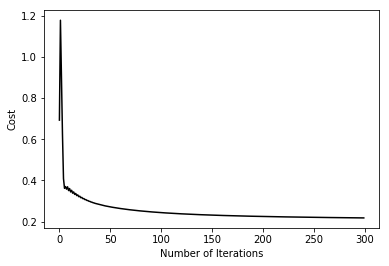

In [94]:
# Plot
model = Logistic_Regression(lam)
model.plot(step, alpha, gd_type='batch', change_alpha=False)

## 2. Stochastic gradient descent
$$w^{n + 1} = w^{n} - \alpha \cdot \frac{dJ_i}{dw}$$
$$\frac{dJ}{dw} = -\frac{1}{n}(y_i - s_i)x_i + 2\lambda w$$
$x_i$ is (D+1)x1, w is (D+1)x1

In [95]:
def stochastic_deriv_cost(x, w, y, lam):
    lamM = np.matrix(np.diag(np.array([lam]*d+[0]))) #(D+1)*(D+1)
    regularization = 2 * lamM * w # (D+1)*1
    rand = randint(0,n-1)
    x = x[rand]
    y = y[rand]
    log_cost = -1/n*(y.item(0) - s(w, x).item(0))*x
    return log_cost.reshape(d+1, 1) + regularization # (D+1)*1

In [204]:
# Tune lambda, alpha and step
lam = 0.000001
alpha = 1.21
step = 450
model = Logistic_Regression(lam)
model.train(trainX, trainY, alpha, step, gd_type='stochastic')

0.2593286217943202

In [205]:
evaluate(model.w, ValidateX, ValidateY)

0.92700000000000005

Number of Steps 0: cost = 0.6931471805599454
Number of Steps 1: cost = 0.3916360947484179
Number of Steps 2: cost = 0.3803179186218624
Number of Steps 3: cost = 0.3835537277022666
Number of Steps 4: cost = 0.38811959736957535
Number of Steps 5: cost = 0.3846360762034696
Number of Steps 6: cost = 0.39875403053621833
Number of Steps 7: cost = 0.3834039493711055
Number of Steps 8: cost = 0.42318132692137694
Number of Steps 9: cost = 0.37273647063302395
Number of Steps 10: cost = 0.5013194220713478
Number of Steps 11: cost = 0.4346670297815785
Number of Steps 12: cost = 0.38550139991065246
Number of Steps 13: cost = 0.4194666151180395
Number of Steps 14: cost = 0.4098702192729987
Number of Steps 15: cost = 0.3809208226166632
Number of Steps 16: cost = 0.401198090108129
Number of Steps 17: cost = 0.4578766478144962
Number of Steps 18: cost = 0.4311824170002609
Number of Steps 19: cost = 0.39727679857577947
Number of Steps 20: cost = 0.3974071294245902
Number of Steps 21: cost = 0.4907040304

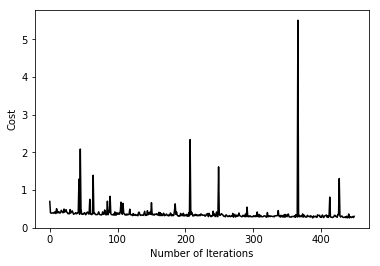

In [206]:
# Plot
model.plot(step, alpha, gd_type='stochastic', change_alpha=False)

### Batch V.S. Stochastic Gradient Descent  
From what I observed from my experiment, to achieve similar accuracy, stochastic approach needs a much smaller lambda, a bigger alpha, and a much bigger step size. From the graphs, we can see that stochastic approach fluctuates much more than batch. This makes sense because stochastic update only depends on one point so it's easily influenced by outliers. We have to use a much bigger alpha because one point's value is smaller than the sum of all points, so we need to "push" this one pointer harder in order to see a slightly significant update on the cost

## 3. Changing alpha

In [244]:
# Tune lambda, alpha and step
lam = 0.000001
alpha = 1.21
step = 450
model = Logistic_Regression(lam)
model.train(trainX, trainY, alpha, step, gd_type='stochastic', change_alpha=True)

0.46927835612464314

In [245]:
evaluate(model.w, ValidateX, ValidateY)

0.74299999999999999

Number of Steps 0: cost = 0.6931471805599454
Number of Steps 1: cost = 1.412356492792777
Number of Steps 2: cost = 0.4047959461998679
Number of Steps 3: cost = 0.43483492083185893
Number of Steps 4: cost = 0.4553977231631949
Number of Steps 5: cost = 0.4480877339228315
Number of Steps 6: cost = 0.44476324674868956
Number of Steps 7: cost = 0.43239587974803473
Number of Steps 8: cost = 0.4699238064782888
Number of Steps 9: cost = 0.4367088020181202
Number of Steps 10: cost = 0.4416141928798483
Number of Steps 11: cost = 0.4463138992013009
Number of Steps 12: cost = 0.49540013804591626
Number of Steps 13: cost = 0.46731485514344484
Number of Steps 14: cost = 0.46141199380971987
Number of Steps 15: cost = 0.5123491239497653
Number of Steps 16: cost = 0.4578869096784495
Number of Steps 17: cost = 0.4789663739877719
Number of Steps 18: cost = 0.4565113388117932
Number of Steps 19: cost = 0.4717725554497079
Number of Steps 20: cost = 0.4382902533077021
Number of Steps 21: cost = 0.5088817833

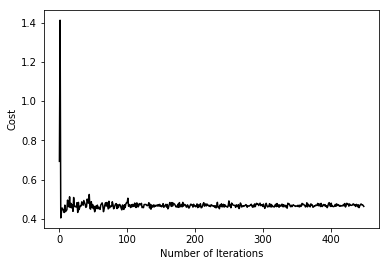

In [246]:
# Plot
model.plot(step, alpha, gd_type='stochastic', change_alpha=True)

### Constant V.S. Dynamic Alpha
I think dynamic alpha should be better than constant because you are learning less and less as you approach the optimal point, so this can avoid jumping around the point without converging. However, in my experiment, using the same other hyperparameters, dynamic alpha seems to be worse than constant alpha. The graph looks more stable than constant though.

## 4. Kaggle

In [248]:
lam = 0.008
alpha = 0.002
step = 300
model = Logistic_Regression(lam)
model.train(trainX, trainY, alpha, step, gd_type='batch')

0.21799329071181534

In [249]:
evaluate(model.w, ValidateX, ValidateY)

0.93600000000000005

In [250]:
y = model.predict(testX)

In [251]:
import pandas as pd
df = pd.DataFrame(data = y, columns=["Category"]) 
df.index.name = "Id"
df.to_csv("./wine.csv")